In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import astropy.units as u
from astropy.constants import h, c, eps0, a0
from collections.abc import Sequence

#from light_old import GaussianBeam
from light import GaussianBeam

sns.set_style('whitegrid')

In [2]:
beam1 = GaussianBeam(
    beam_direction_vec=(1,0,0),
    pol_Jones_vec=(1,0),
    lambda_=1064,
    w0=(350, 175),
    P=11,
    z0=0,
)

beam2 = GaussianBeam(
    beam_direction_vec=(-1,0,0),
    pol_Jones_vec=(1,0),
    lambda_=1064,
    w0=(350, 175),
    P=11,
    z0=0,
)

In [8]:
x = np.linspace(-1, 1, 101) * u.um
y = np.linspace(-1000, 1000, 101) * u.um
z = np.linspace(-1000, 1000, 101) * u.um

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

In [9]:
Evec1 = beam1.E_vec(X, Y, Z)
Evec2 = beam2.E_vec(X, Y, Z)

In [15]:
L = Evec1 + Evec2
L = np.sqrt(L[0]*np.conjugate(L[0]) + L[1]*np.conjugate(L[1]) + L[2]*np.conjugate(L[2]))
L.shape

(101, 101, 101)

/home/lelo/anaconda3/envs/lightmatter/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/lelo/anaconda3/envs/lightmatter/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


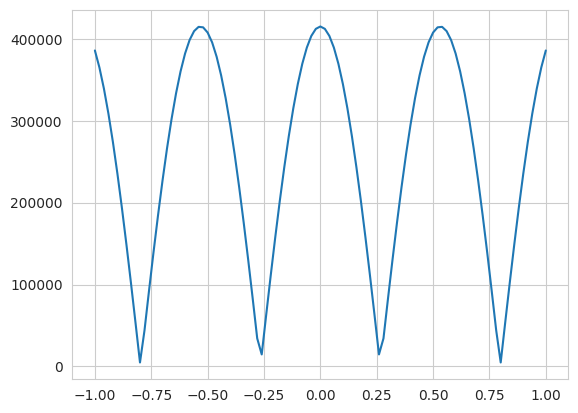

In [16]:
plt.plot(x.value, L[:, 50, 50].value)

NameError: name 'E' is not defined

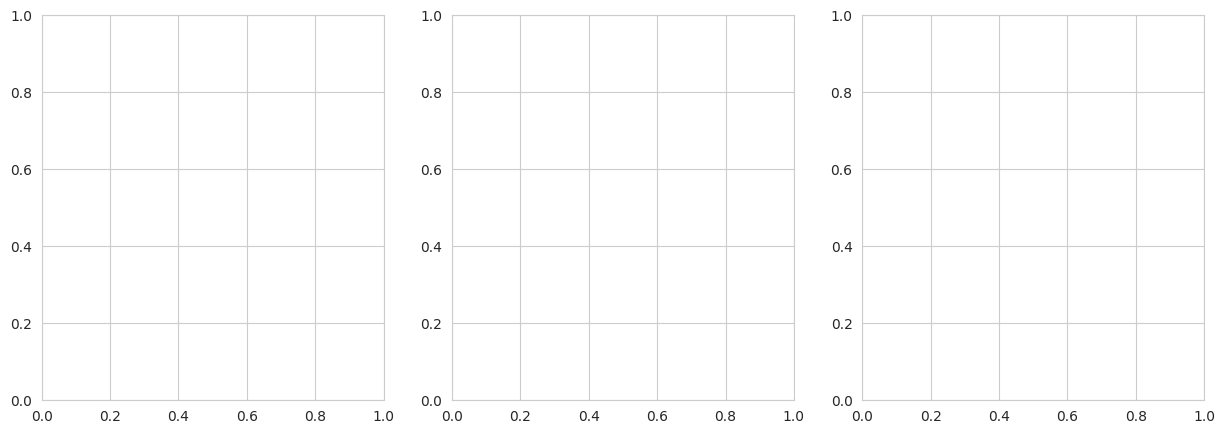

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].pcolormesh(X[:,:,0], Y[:,:,0], np.abs(E[:,:,0].value)**2)
axs[0].set_title('z=-1000cm')
axs[0].set_xlabel('x (um)')
axs[0].set_ylabel('y (um)')
axs[0].set_aspect('equal')

axs[1].pcolormesh(X[:,:,50], Y[:,:,50], np.abs(E[:,:,50].value)**2)
axs[1].set_title('z=0cm')
axs[1].set_xlabel('x (um)')
axs[1].set_ylabel('y (um)')
axs[1].set_aspect('equal')

axs[2].pcolormesh(X[:,:,100], Y[:,:,100], np.abs(E[:,:,100].value)**2)
axs[2].set_title('z=1000cm')
axs[2].set_xlabel('x (um)')
axs[2].set_ylabel('y (um)')
axs[2].set_aspect('equal')

fig.tight_layout()
